Only for reference
<br/>
see cwubc.ipynb for latest work

In [1]:
import os
import os.path
from os import listdir

import sys
sys.path.append("/Users/bxie/programming/ai2_summarizer/")
from ai2summarizer import elementTreeFromLines, findBlockInfo, formatLists, sortToDict, projectToJSON

import json
import zipfile
import xml.etree.ElementTree as ET

import re
from collections import Counter
import csv
import pickle

#plotting
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib

%matplotlib inline
matplotlib.style.use('ggplot')
pd.options.display.mpl_style = 'default'

root_directory = "/Users/bxie/Documents/ai2_users_random/"
THRESHOLD = 20 #min number of projects user must have


#regex to ignore non-project files
ignore = 'python|\.|README'
regexp=re.compile(ignore) #use: regexp.search(fname)

running...
done


In [3]:
"""
Adapted from Maja's Project Summarizer (bkyToSummary())
Gets data from blocks file
"""
def parse_blocks(bky_dir):
    with open(bky_dir) as f:
        bkyLines = f.readlines()
    rootElt = elementTreeFromLines(bkyLines, bky_dir)
    if rootElt.tag == 'MALFORMED':
        return 'MALFORMED BKYFILE'
    elif not rootElt.tag == 'xml':
        raise RuntimeError('bkyToSummary: Root of bky file is not xml but ' + rootElt.tag)
    else:
        listOfBlocks = []
        listOfOrphans = []
        top  = []
    if len(rootElt) < 1:
        return 'NO BLOCKS'
    for child in rootElt:
        if child.tag == 'block':
            top.append(child.attrib['type'])
            type = child.attrib['type']
            component_selector = False
            for grandchild in child:
                if grandchild.tag == 'title' or grandchild.tag =='field':
                    if grandchild.attrib['name'] == 'COMPONENT_SELECTOR':
                        component_selector = True
            if type == 'component_event' or type  == 'global_declaration' or type == 'procedures_defnoreturn' or type == 'procedures_defreturn' or type == 'procedures_callnoreturn' or type == 'procedures_callreturn' or type[:-4] == 'lexical_variable':
                listOfBlocks += findBlockInfo(child)
            elif component_selector:
                listOfBlocks += findBlockInfo(child)
            else:
                listOfOrphans += findBlockInfo(child)
    if len(listOfBlocks) == 0:
        blocks = 'NO ACTIVE BLOCKS'
    else:
        blocks = formatLists(listOfBlocks)
    if len(listOfOrphans) == 0:
        orphans = 'NO ORPHAN BLOCKS'
    else:
        orphans = formatLists(listOfOrphans)
    return {'*Top Level Blocks': sortToDict(top), 'Active Blocks': blocks, 'Orphan Blocks': orphans}

In [7]:
"""
Navigate directory to get blocks data for projects
"""

# return dictionary of (user ids, num projects) 
# for users w/ at least min_num_projects
def get_users(min_num_projects):
    #regex to ignore non-project files
    ignore = 'python|\.|README'
    regexp=re.compile(ignore) #use: regexp.search(fname)

    new_fnames = filter(lambda x: regexp.search(x) is None, listdir(root_directory))
    super_users = {}

    for fname in new_fnames:
        num_projects = len(get_all_projects(fname))
#         num_projects = len(listdir(root_directory + str(fname)))
        if num_projects > min_num_projects:
            super_users[fname] = num_projects

    return super_users

# Given user_id (user directory name), return list of all project ids
def get_all_projects(user_id):
    unfiltered_project_names = listdir("{}{}".format(root_directory, user_id))
    project_names = filter(lambda x: x.isdigit(), unfiltered_project_names)
    return project_names

#given user id and project id, return project summary (as dictionary)
def get_summary(user_id, project_id):
    pass
    

# Given project_id (user directory name), return lists of all active blocks, orphaned blocks
def get_blocks(user_id, project_id):
    project_dir = "{}{}/{}/".format(root_directory, user_id, project_id)
    all_project_files = listdir(project_dir)
    block_files = filter(lambda x: ".bky" in x, all_project_files)
    blocks_count = Counter({})
    orphan_count = Counter({})
    for fname in block_files:
        proj_blocks_data = parse_blocks("{}{}".format(project_dir, fname))
        
        #type checking here b/c parse_blocks returns string if no blocks exist (dict if blocks do)
        if type(proj_blocks_data) != str:            
            if type(proj_blocks_data['Active Blocks']) != str:
#                 print 'has active'
                blocks_count += Counter(proj_blocks_data['Active Blocks']['Types'])

            if type(proj_blocks_data['Orphan Blocks']) != str:
#                 print 'has orphans'
                orphan_count += Counter(proj_blocks_data['Orphan Blocks']['Types'])
    
    return dict(blocks_count), dict(orphan_count)

# Given blocks dict, save to CSV
def save_blocks_to_csv(blocks_dict, new_fname_path):
    writer = csv.writer(open("{}.csv".format(new_fname_path), 'wb'))
    for key, value in blocks_dict.items():
        writer.writerow([key, value])
    return True

In [8]:
"""
Get "all" types of blocks
"""
# get count of all blocks by users with at least n (threshold) projects
def get_all_blocks(threshold=0):
    counter_active = Counter({})
    counter_orphan = Counter({})    
    
    for user_id in get_users(threshold):
        for project_id in get_all_projects(user_id):
#             print "{}, {}".format(user_id, project_id)
            active, orphan = get_blocks(user_id, project_id)
            counter_active += Counter(active)
            counter_orphan += Counter(orphan)
    return dict(counter_active), dict(counter_orphan)

# get list of all block types
# BXX TODO: clean up block types (improper spelling, weird types)
def get_all_block_types(active_blocks, orphan_blocks):
    return list(set(active_blocks.keys() + orphan_blocks.keys()))

def load_block_types(fname):
    block_types = open(fname, 'rb')
    output = pickle.load(block_types)
    block_types.close()
    return output

def save_block_types(fname):
    block_types = open(fname, 'wb')
    pickle.dump(BLOCK_TYPES, block_types)
    block_types.close()


In [9]:
"""
Create matrix for trajectories
"""

# order of this is important
block_types_fname = 'block_types.pkl'
BLOCK_TYPES = load_block_types(block_types_fname)
# BLOCK_TYPES = get_all_block_types(all_users_blocks[0], all_users_blocks[1])


def get_all_trajectories(threshold=THRESHOLD):
    user_ids = get_users(threshold)
    user_traj_vectors = [] #list of user trajectory vectors
    for uid in user_ids:
        V_u = get_trajectory(uid)
        user_traj_vectors.append(V_u)
    return np.vstack(user_traj_vectors)

# given a user_id, return trajectory as vector of # of blocks used at each project
# BXX TODO: Add weighting
def get_trajectory(user_id, threshold=THRESHOLD):
    P_u = get_freq_matrix(user_id, threshold)
    # print P_u[:, BLOCK_TYPES.index('color_make_color')]
    P_c = np.cumsum(P_u, axis = 0)
    # print P_c[:, BLOCK_TYPES.index('color_make_color')]
    P_b = P_c>0
    # print P_b[:, BLOCK_TYPES.index('color_make_color')]
    V_u = np.sum(P_b, axis=1)
    return V_u

# given user_id, return matrix of frequency of blocks of each project 
# output: n x d matrix where n=# of projects (THRESHOLD), d = # of block types
def get_freq_matrix(user_id, threshold=THRESHOLD):
#     print "{}".format(user_id)
    output = np.zeros((threshold, len(BLOCK_TYPES)))
    project_ids = get_all_projects(user_id)[:threshold] # getting first n projects from user
    for i in range(threshold):
        pid = project_ids[i]
        blocks = get_blocks(user_id, pid)[0]
#         print blocks
        for blk, count in blocks.items():
            output[i, BLOCK_TYPES.index(blk)] = count
    return output

In [10]:
T_all = get_all_trajectories(20)
T_all.shape

T_all_mean = T_all.mean(0)

TypeError: findBlockInfo() takes exactly 3 arguments (1 given)

In [8]:
super_users = get_users(THRESHOLD)


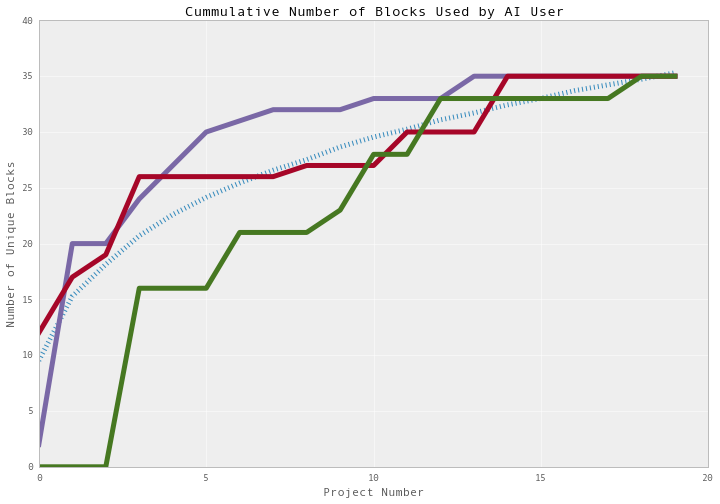

In [36]:
plt.figure(figsize=(12,8))

plt.plot(T_all_mean, linestyle='dotted', linewidth=5)
plt.xlabel('Project Number')
plt.ylabel('Number of Unique Blocks')
# plt.plot(T_all[50,:])
# plt.plot(T_all[68,:])
# plt.plot(T_all[120,:])

plt.plot(T_all[9,:], linewidth=5) #purple
plt.plot(T_all[20,:], linewidth=5) #red
# plt.plot(T_all[48,:])
plt.plot(T_all[51,:], linewidth=5) #green
plt.title("Cummulative Number of Blocks Used by AI User")
# for i in range(T_all.shape[0]):
#     plt.plot(T_all[i,:])

In [9]:
super_users_blocks = get_all_blocks(threshold=20)
print 'done, bitch'

000411, 4505159310770176
has active
000411, 4529963832180736
has active
has active
000411, 4670671491694592
has active
000411, 4672141171621888
has active
000411, 4679033696550912
has active
000411, 4699900974465024
has active
000411, 4773306177683456
has active
000411, 4778650262044672
000411, 4793489512464384
has active
000411, 4813157950291968
has active
000411, 4835571458375680
has active
has active
has active
000411, 4910019847913472
has active
000411, 5101060672716800
has active
000411, 5197277964533760
has active
000411, 5231652164861952
has active
000411, 5627773592797184
has active
000411, 5656637115203584
has active
000411, 5666612621344768
has active
000411, 5716476129443840
has active
000411, 5738318211842048
has active
000411, 5757830990659584
has active
000411, 5869656277516288
has active
000411, 5899467913953280
has active
000411, 5950625068089344
has active
has orphans
000411, 5954189068861440
has active
000411, 5973298590515200
has active
000411, 6065863306248192
00041

In [9]:
all_users_blocks = get_all_blocks()

TypeError: findBlockInfo() takes exactly 3 arguments (1 given)

In [133]:
block_types = open('block_types.pkl', 'wb')
pickle.dump(BLOCK_TYPES, block_types)
block_types.close()
block_types = open('block_types.pkl', 'rb')
print pickle.load(block_types)

['controls_getStartValue', 'ButtonCorrect_Click', 'BiggerDot_Click', 'PAH_Click', 'compondnt_set_get', 'component_set_het', 'math_number', 'GoldSprite5_getproperty', 'Desired_Locations_Initialize', 'math_cos', 'Catch_Phrases_BeforePicking', 'LblGrossPay_setproperty', 'Time_setproperty', 'Canvas1_DrawCircle', 'componenv_set_get', 'NumerotLabel_setproperty', 'register_setproperty', 'ChB1_ManBaiSui_getproperty', 'register_getproperty', 'GoldSprite1_MoveTo', 'Noice_Vibrate', 'Button5_getproperty', 'PictoBoxDeluxe_TakePicture', 'procedures_defreturn', 'eomponent_set_get', 'Canvas1_setproperty', 'comnonent_component_block', 'ChB3_SanSui_setproperty', 'Screen1_setproperty', 'EuroPlusLabel1_setproperty', 'ButtonAdd_Click', 'local_declaration_statement', 'FusiontablesControl1_setproperty', 'Refresh_Click', 'Img6_GuLi_setproperty', 'Screen2_setproperty', 'ScoreLabel_setproperty', 'SpeechRecognizer1_AfterGettingText', 'color_pink', 'TinyWebDB1_GetValue', 'Player1_Vibrate', 'result_setproperty', '

In [27]:
# save_blocks_to_csv(all_users_blocks[0], 'all_users_active')

True

In [8]:
BLOCK_TYPES = get_all_block_types(all_users_blocks[0], all_users_blocks[1])

NameError: name 'all_users_blocks' is not defined

In [40]:
# get list of all blocks
# BXX TODO: clean up block types (improper spelling, weird types)
all_blocks = list(set(all_users_blocks[0].keys() + all_users_blocks[1].keys()))

In [46]:
len(get_users(20))

141

In [47]:
uid = "000411"
pid = "4505159310770176"
 
path = "{}{}/{}".format(root_directory, uid, pid)
projectToJSON(path)

Exception: project is not .aia or  .zip